# Expanding on Ito et al. (2017) to recover simulated task activity and connectivity matrix


Set up environment

In [1]:
from collections import OrderedDict
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm

Import custom modules

In [2]:
sys.path.append('../')
sys.path.append('../../utils/')

# Primary module with most model functions
import model

# Module for FC regression
import multregressionconnectivity as mreg

Helper functions

In [3]:
phi = lambda x: np.tanh(x)

inv_phi = lambda x: np.arctanh(x)

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


## Neural network model

In this notebook we expand on simulations described in [Ito et al. (2017)](https://www.nature.com/articles/s41467-017-01000-w.pdf). Ito et al. propose a dynamic neural network model to simulate resting state and task data. Accordingly change in activity in each node is a function of the local connectivity determined by $s$, global connectivity determined by $g$ and task activity for that node described in $I$

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

where transformation function $\phi$ is
\begin{equation*}
\phi(x) = \tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{2x}-1}{e^{2x}+1}
\end{equation*}

This transformation is intended to introduce *"a nonlinearity to the interactions among units that is
similar to aggregate nonlinearity from neuronal action potentials"* as explained in [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). The effect of this transformation can be seen below in the attenuated signal of the transformed timeseries.

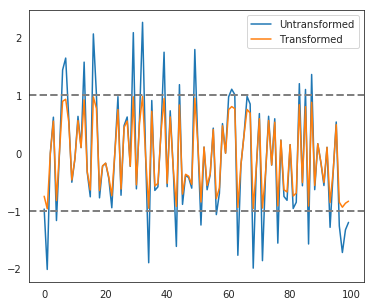

In [4]:
plt.rcParams["figure.figsize"][0] = 6
plt.rcParams["figure.figsize"][1] = 5
a = np.random.normal(size=100)
pa = phi(a)
plt.plot(a, label="Untransformed")
plt.plot(pa, label="Transformed")
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axhline(y=-1,linewidth=2, color='gray', ls = "--")
plt.legend()

In Ito et al. (2017) $\tau_i$, $s$, $g$ and $dt$ are set to 1. This simplifies the equation to:

\begin{equation*}
x_i(t) + \frac{dx_i}{dt} = \phi\big(x_i(t)\big) + \sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big) + I_i(t)
\end{equation*}

***Create structural and synaptic network***

One hub and two local networks

In [5]:
# Parameters for subject's networks
ncommunities = 3
innetwork_dsity = .60
outnetwork_dsity = .08
hubnetwork_dsity = .25

nodespercommunity = 35
totalnodes = nodespercommunity*ncommunities

In [6]:
# Construct structural matrix
S = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=False)
# Construct synaptic matrix
W = model.generateSynapticNetwork(S, showplot=False)

Text(0.5, 1.0, 'Synaptic Weight Matrix -- Coupling Matrix')

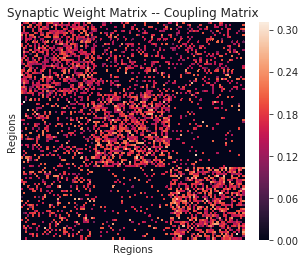

In [7]:
plt.rcParams["figure.figsize"][0] = 5
plt.rcParams["figure.figsize"][1] = 4
sns.heatmap(W, xticklabels=False, yticklabels=False)
plt.xlabel('Regions')
plt.ylabel('Regions')
plt.title("Synaptic Weight Matrix -- Coupling Matrix")

Note in this matrix:

`W[..., x]` : column x of matrix denotes all outgoing connection weights from node x  
`W[x, ...]` : row x of matrix denotes all incoming connection weights to node x

In [8]:
## Set up simulation parameters
dt = 1.0
tau = 1.0
g = 1.0
s = 1.0

### Task activity 

***Hub network stimulation***

In [9]:
Ci = np.repeat(np.arange(ncommunities),nodespercommunity) # Construct a community affiliation vector
hub_ind = np.where(Ci==0)[0] # Identify the regions associated with the hub network (hub network is by default the 0th network)

# Set number of time points for each task
Tmax = 100000 

T = np.arange(0,Tmax,dt)
    
# Construct timing array for convolution -- this timing is irrespective of the task being performed
# Tasks are only determined by which nodes are stimulated
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%2000>500 and t%2000<1000:
        tasktiming[0,t] = 1.0

Block design where stimulus is ON for 500 ms every 2 seconds looks like:

(-0.1, 1.2)

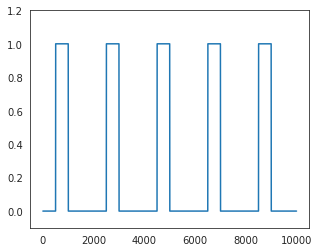

In [10]:
plt.plot(T[:10000], tasktiming[0,:10000])
plt.ylim(top = 1.2, bottom = -0.1)

In [11]:
stimtimes = {}

topdown_only = range(1,2)
task = 1

taskcount = task-np.min(topdown_only)
stimsize = np.floor(nodespercommunity/3.0)
stim_nodes = np.arange((taskcount)*stimsize,(taskcount)*stimsize+stimsize,dtype=int)
stimtimes[task] = np.zeros((totalnodes,len(T)))

# When task is ON the activity for a stim_node at that time point is .5
for t in range(len(T)):
    if tasktiming[0,t] == 1:
        stimtimes[task][stim_nodes,t] = .5

Activated nodes in the hub network *only* (making it a top-down task) are:

In [12]:
stim_nodes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

`taskdata` is an $n$ by $t$ matrix containing the timeseries for each node where $n$-rows are for nodes and $t$ columns are for the time points.

It is generated by updating each column (each time point) for **all nodes**  

At each time point the differential equation describing the change in activity is solved using the [Runge-Kutta second order method](https://lpsa.swarthmore.edu/NumInt/NumIntSecond.html). Runge-Kutta methods are used to discretize the problem of updating values for continuous time when solving differential equations. Ito et al. hypothesize the differential equation determining the amount of change in each timestep as:

\begin{equation*}
\frac{dx_i}{dt} = \frac{-x_i(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + s\phi\big(x_i(t)\big) + I_i(t)}{\tau_i}
\end{equation*}

Thus `taskdata` for all nodes $x_i$ consists of the current activity plus a weighted sum of approximate changes in activity calculated using the differential equation.

\begin{equation*}
x_{i}(t+dt) = x_{i}(t) + \frac{k1_{i}+k2_{i}}{2}
\end{equation*}

The first derivative based on $t(0)$ that is used for the approximation is

\begin{equation*}
k1_{i} = \frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}
\end{equation*}

$\hat{I}_{i}(t)$ is the spontaneous activity that is the sum of randomly generated noise and task-related stimulation ($\hat{I}_{i}(t) = {I}_{i}(t)+\epsilon(t)$). Since the column-vector of task-related stimulation activity is very sparse ($|I_{i}(t)| \neq 0$ only for $i$ that is the third of the hub nodes and only for a short window of timepoints $t$) **most of the activity feeds into updating the activity of a node is noise (which in this framework is the equivalent of rest activity)**.

Using this slope the first intermediate approximation at the endpoint is

\begin{equation*}
x_{i}^*(t+dt) = x_{i}(t) + k1_{i} dt
\end{equation*}

and the second order approximation for the change in activity is

\begin{equation*}
k2_{i} = \frac{-x_{i}^*(t+dt) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}^*(t+dt)\big) + \hat{I}_{i}(t+1)}{\tau}
\end{equation*}

If we discretize and work through the algebra the row-wise (node-centric) 'expanded' GLM for the column-wise (timepoint-centric) generated data using the Runge-Kutte method would be:

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{k1_{i}+k2_{i}}{2}
\end{equation*}

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{\frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}+\frac{-x_{i}^*(t+dt) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}^*(t+dt)\big) + \hat{I}_{i}(t+1)}{\tau}}{2}
\end{equation*}

Replacing $x_{i}^*(t+dt)$

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{\frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}+\frac{-x_{i}(t) - k1_{i} dt + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}(t) + k1_{i} dt\big) + \hat{I}_{i}(t+1)}{\tau}}{2}
\end{equation*}

Getting ride of $s, g, \tau, dt$ (as they are 1 in these simulations) cleaning up and moving the denominator

\begin{equation*}
2x_{i}(t+1) = \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t) - k1_{i} + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + \phi\big(x_{i}(t) + k1_{i} \big) + \hat{I}_{i}(t+1)
\end{equation*}

Replacing $k1_i$

\begin{equation*}
2x_{i}(t+1) = \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t) - \Bigg[-x_{i}(t) + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg] + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + \phi\big(x_{i}(t) + \Bigg[-x_{i}(t) + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]\big) + \hat{I}_{i}(t+1)
\end{equation*}

Cleanup

\begin{equation*}
2x_{i}(t+1) = x_{i}(t) + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + \phi\Bigg(\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg) + \hat{I}_{i}(t+1)
\end{equation*}

We can use this equation to expand the traditinal GLM. A traditional GLM would have modeled

\begin{equation*}
x_{i}(t) = h(t) \circledast I(t) + \epsilon_i(t)
\end{equation*}

that is the activity of a voxel at a given time point would have been a function of the convolved task activity for that node at that time point plus some noise (For these simulations we ignore other movement confounds etc. included in level 1 models in real data).  

With the expanded model derived from the approximation of the differential equation we model the value at the next time step of a given node ($x_{i}(t+1)$) as a function of their activity in the current time step ($x_{i}(t)$), the transformed activity in the next time step from all other nodes weighted by their connection weights to the given node ($\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg)$), the transformed activity in the current time step resulting from other nodes, self and task ($\phi\Bigg(\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg)$) and task activity for that node in the next time step ($\hat{I}_{i}(t+1)$).

In [13]:
out = model.networkModel(W,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
                                          I=stimtimes[task], noise=1)
taskdata = out[0]
noise = out[1]
#taskdata = model.networkModel(W,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
#                                          I=stimtimes[task], noise=1)

## Extending GLM to recover true task activity and connectivity matrix

Note: Extending the GLM in this way is intended to account for the connectivity between nodes and how **task** activity in the previous step affects task activity in the current step for a given node. I don't think this is the same thing as 'subtracting out' resting state to look at the remaining task activity.


### Correcting task activity knowing the connectivity matrix

With real data we can estimate the weight matrix from resting state but we wouldn't know which nodes a task activates. Thus we wouldn't have access to $\hat{I}_i(t)$ but only to $\hat{I}(t)$, i.e. assume that the regressor has the same effect on all nodes. 

Running the model

\begin{equation*}
2x_{i}(t+1) = x_{i}(t) + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}(t+1)\big)\Bigg) + \phi\Bigg(\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}(t)\Bigg) + \hat{I}(t+1)
\end{equation*}

In [14]:
#Using first third of the data for speed of estimation
taskdata_short = copy.copy(taskdata[:,:15000])

In [15]:
y = copy.copy(taskdata_short)
I = copy.copy(stimtimes[task][:,:15000])

In [16]:
ntimepoints = y.shape[1]
nregions = y.shape[0]

#Initialize empty variables
ucr_task = np.zeros((nregions))
ext_cur_node = np.zeros((nregions)) 
ext_other_ns_next_spont = np.zeros((nregions)) 
ext_phi_others_cur_spont = np.zeros((nregions)) 
ext_task = np.zeros((nregions))


In [17]:
for region in range(0, nregions):
    
    cur_y = y[region,:]
    incoming_connections = W[region, :]
    incoming_connections = np.delete(incoming_connections,region)
    #task_reg = I[region,:]
    task_reg = I[0,:]

    ucr_mod = sm.OLS(cur_y, task_reg)
    ucr_res = ucr_mod.fit()
    ucr_task[region] = ucr_res.params[0]

    #Extended model 
    next_y = 2*cur_y[1:] #shift column up to predict next multiplied activity

    cur_y = cur_y[:-1] #drop last time point

    drop_region = [region]
    other_ns_next_spont = np.delete(y, drop_region, axis=0)[:,1:] #dropping first col/timepoint
    other_ns_next_spont = other_ns_next_spont.T
    other_ns_next_spont = np.apply_along_axis(phi, 0, other_ns_next_spont)
    other_ns_next_spont = np.sum(other_ns_next_spont*incoming_connections, axis = 1)

    other_ns_cur_spont = np.delete(y, drop_region, axis=0)[:,:-1] #dropping last col/timepoint
    other_ns_cur_spont = other_ns_cur_spont.T
    other_ns_cur_spont = np.apply_along_axis(phi, 0, other_ns_cur_spont)
    other_ns_cur_spont = np.sum(other_ns_cur_spont*incoming_connections, axis = 1)

    cur_y_phi = phi(cur_y)

    cur_n_cur_spont = task_reg[:-1]
    
    phi_others_cur_spont = phi(other_ns_cur_spont + cur_y_phi + cur_n_cur_spont)
    
    cur_n_next_spont = task_reg[1:]

    ext_des_mat = np.concatenate((cur_y.reshape(-1,1), other_ns_next_spont.reshape(-1,1)), 1)
    ext_des_mat = np.concatenate((ext_des_mat, phi_others_cur_spont.reshape(-1,1)), 1)
    ext_des_mat = np.concatenate((ext_des_mat, cur_n_next_spont.reshape(-1,1)), 1)

    ext_mod = sm.OLS(next_y, ext_des_mat)
    ext_res = ext_mod.fit()
    ext_params = ext_res.params

    ext_cur_node[region] = ext_params[0]
    ext_other_ns_next_spont[region] = ext_params[1]
    ext_phi_others_cur_spont[region] = ext_params[2]
    ext_task[region] = ext_params[3]

#### Task betas reduced after correction?

Yes, but not the level of 'true' activity (0.5) for all activated nodes.

In [18]:
task_betas = pd.DataFrame(data = {'ucr_task': ucr_task,
                         'ext_task': ext_task})

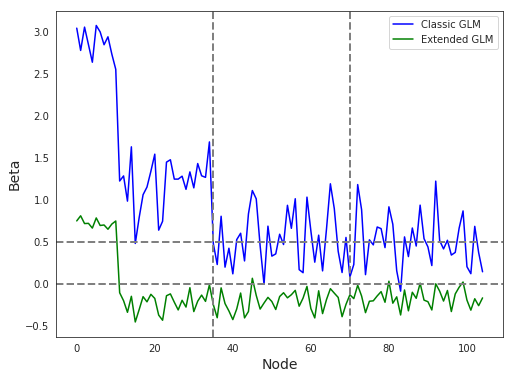

In [19]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 6
plt.plot(task_betas['ucr_task'], color = "blue", label = "Classic GLM")
plt.plot(task_betas['ext_task'], color = "green", label = "Extended GLM")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=.5,linewidth=2, color='gray', ls = "--")
plt.axhline(y=0,linewidth=2, color='gray', ls = "--")
plt.axvline(x=35,linewidth=2, color='gray', ls = "--")
plt.axvline(x=70,linewidth=2, color='gray', ls = "--")
plt.legend(loc="best")

The mean of the task coefficients estimated for non-stimulated nodes is not different from the true value of 0 and the mean of the task coefficients estimated for the stimulated nodes is not different from the true value 0.5. I.e. it works.

In [20]:
stats.ttest_ind(np.delete(ext_task, stim_nodes), np.repeat(0, 94))

Ttest_indResult(statistic=-15.712149196667422, pvalue=5.890136430287752e-36)

In [21]:
stats.ttest_ind(ext_task[stim_nodes], np.repeat(0.5,11))

Ttest_indResult(statistic=15.755078763729752, pvalue=9.696071406634665e-13)

## Generalizable function for the extended GLM

The loop above that runs an extended GLM on each node's timeseries accounting for its local and global connectivity uses the simplified differential equation that depends on the set values of the parameters.  

But the parameters used in generating the neural network ($dt$, $\tau$, $g$, $s$) need not be 1. Therefore the extended GLM model would not always simplify to the equation above. To be able to test this method of extending the traditional GLM more generally pn different network and task structures we need to algebraically write out the full equation including all the parameters that describes how activity in the next time step of each node is updated ($x_{i}(t+1)$).


\begin{equation*}
k1_{i} = \frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}
\end{equation*}

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{\frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}+\frac{-x_{i}(t) - k1_{i} dt + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}(t) + k1_{i} dt\big) + \hat{I}_{i}(t+1)}{\tau}}{2}
\end{equation*}

To write out a general equation for $x_i(t+1)$ first we replace the $k1_i$ in the equation. Since $k1_i$ appears always in the context of $x_i(t)+k1_idt$ we plug in the formula for $k1_i$ into this expression and simplify

\begin{equation*}
x_{i}(t) + k1_{i}dt = x_{i}(t)+dt\frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}
\end{equation*}

\begin{equation*}
x_{i}(t) + k1_{i}dt = \frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]
\end{equation*}


Then we use this expression in the formula of $x_{i}(t+1)$ 

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + \frac{dt}{2\tau}\Bigg[-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t) - \big(x_{i}(t) + k1_{i} dt\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}(t) + k1_{i} dt\big) + \hat{I}_{i}(t+1)\Bigg]
\end{equation*}

Plugging in $x_{i}(t) + k1_{i}dt$

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + \frac{dt}{2\tau}\Bigg[-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t) - \big(\frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(\frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]\big) + \hat{I}_{i}(t+1)\Bigg]
\end{equation*}

Simplifying common terms

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + \frac{dt}{2\tau}\Bigg[\frac{dt-2\tau}{\tau}x_{i}(t) + \frac{\tau-dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg] + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(\frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]\big) + \hat{I}_{i}(t+1)\Bigg]
\end{equation*}

Extracting $x_{i}(t)$ outside the rest of the expression

\begin{equation*}
x_{i}(t+1) = \frac{2\tau^2+dt(dt-2\tau)}{2\tau^2}x_{i}(t) + \frac{dt}{2\tau}\Bigg[\frac{\tau-dt}{\tau}\Bigg(g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(\frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg(g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg)\big) + \hat{I}_{i}(t+1)\Bigg]
\end{equation*}

This is a pretty messy expression. In words it describes the activity in the next time point for a node as a function of:
- current node activity 
- current activity depending on connectivity with other nodes, local connectivity and task stimulation 
- activity in the next time step depending on connectivity with other nodes, first order approximation in the current node and task stimulation  
all of which are weigted by different constants that depends on the time steps

Since this is just the generalized form of the simplified extended GLM equation including all the terms that were previously omitted because their values were known to be 1 we should get the same results if we rewrite the code for the extended GLM with this equation.

In [22]:
def run_ucr_glm(all_nodes_ts, task_reg):
    nregions = all_nodes_ts.shape[0]
    ucr_task_betas = np.zeros((nregions))
    
    for region in range(0, nregions):
        cur_y = all_nodes_ts[region,:]
        ucr_mod = sm.OLS(cur_y, task_reg)
        ucr_res = ucr_mod.fit()
        ucr_task_betas[region] = ucr_res.params[0]
    
    return ucr_task_betas

In [62]:
def run_ext_glm(all_nodes_ts, task_reg, weight_matrix, dt = 1, tau = 1, g = 1, s = 1): 
    
    nregions = all_nodes_ts.shape[0]
    ext_task_betas = np.zeros((nregions))
    
    for region in range(0, nregions):
        cur_y = all_nodes_ts[region,:]
        incoming_connections = weight_matrix[region, :]
        incoming_connections = np.delete(incoming_connections,region)
        drop_region = [region]
        
        #DV
        next_y = cur_y[1:] #shift column up to predict activity in next time point

        #IV 1
        cur_y = cur_y[:-1] #drop last time point
        cur_y = ((2*(tau**2)+dt*(dt-2*tau))/(2*(tau**2)))*cur_y
        
        #IV 2
        other_ns_cur_spont = np.delete(y, drop_region, axis=0)[:,:-1] #dropping last col/timepoint
        other_ns_cur_spont = other_ns_cur_spont.T
        other_ns_cur_spont = np.apply_along_axis(phi, 0, other_ns_cur_spont)
        other_ns_cur_spont = np.sum(other_ns_cur_spont*incoming_connections, axis = 1) 
        other_ns_cur_spont = (dt/(2*tau))*((tau-dt)/tau)*g*other_ns_cur_spont
        
        #IV 3
        cur_y_phi = all_nodes_ts[region,:]
        cur_y_phi = cur_y_phi[:-1]
        cur_y_phi = (dt/(2*tau))*((tau-dt)/tau)*s*phi(cur_y_phi)
        
        #IV 4
        cur_n_task = (dt/(2*tau))*((tau-dt)/tau)*task_reg[:-1]
        
        #IV 5
        other_ns_next_spont = np.delete(y, drop_region, axis=0)[:,1:] #dropping first col/timepoint
        other_ns_next_spont = other_ns_next_spont.T
        other_ns_next_spont = np.apply_along_axis(phi, 0, other_ns_next_spont)
        other_ns_next_spont = np.sum(other_ns_next_spont*incoming_connections, axis = 1)
        other_ns_next_spont = (dt/(2*tau))*g*other_ns_next_spont
        
        #IV 6
        cur_n_first_appr = all_nodes_ts[region,:]
        cur_n_first_appr = cur_n_first_appr[:-1]
        cur_n_first_appr = ((tau-dt)/tau)*cur_n_first_appr
        tmp = np.delete(all_nodes_ts, drop_region, axis=0)[:,:-1] #dropping last col/timepoint
        tmp = tmp.T
        tmp = np.apply_along_axis(phi, 0, tmp)
        tmp = np.sum(tmp*incoming_connections, axis = 1) 
        tmp = (dt/tau)*g*tmp
        cur_n_first_appr = cur_n_first_appr+tmp
        tmp = all_nodes_ts[region,:]
        tmp = tmp[:-1]
        tmp = s*phi(tmp)
        cur_n_first_appr = cur_n_first_appr+tmp
        cur_n_first_appr = cur_n_first_appr+task_reg[:-1]
        cur_n_first_appr = (dt/(2*tau))*s*phi(cur_n_first_appr)
        
        #IV 7
        cur_n_next_task = (dt/(2*tau))*task_reg[1:]
        
        #All IVs in design matrix
        ext_des_mat = np.concatenate((cur_y.reshape(-1,1), other_ns_cur_spont.reshape(-1,1)), 1)
        ext_des_mat = np.concatenate((ext_des_mat, cur_y_phi.reshape(-1,1)), 1)
        ext_des_mat = np.concatenate((ext_des_mat, cur_n_task.reshape(-1,1)), 1)
        ext_des_mat = np.concatenate((ext_des_mat, other_ns_next_spont.reshape(-1,1)), 1)
        ext_des_mat = np.concatenate((ext_des_mat, cur_n_first_appr.reshape(-1,1)), 1)
        ext_des_mat = np.concatenate((ext_des_mat, cur_n_next_task.reshape(-1,1)), 1)

        ext_mod = sm.OLS(next_y, ext_des_mat)
        ext_res = ext_mod.fit()
        ext_params = ext_res.params

        ext_task_betas[region] = ext_params[6]
    
    return ext_task_betas

